<a href="https://colab.research.google.com/github/nngt0101/nngt.0101/blob/main/RFMmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# kết nối với drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Nguyễn Ngọc Gia Tuệ K184060768 

In [ ]:
# Kết nối với thư viện 
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Đọc file data csv  từ gg drive
df = pd.read_csv('/content/drive/MyDrive/DA_K18406_K184060768_NguyenNgocGiaTue_RFM/Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [ ]:
# Show 3 cột đầu của data
df.head(3)

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52


In [ ]:
# Show thông tin của data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125000 entries, 0 to 124999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   customer_id  125000 non-null  object        
 1   trans_date   125000 non-null  datetime64[ns]
 2   tran_amount  125000 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.9+ MB


In [ ]:
# thời gian giao dịch từ nhỏ nhất đến lớn nhất 
print(df['trans_date'].min(), df['trans_date'].max())

2011-05-16 00:00:00 2015-03-16 00:00:00


In [ ]:
# ngày thực hiện nghiên cứu 1/4/2015 để phù hợp với dữ liệu em tìm ra  , số ngày kể từ ngày thực hiện nghiên cứu 
sd = dt.datetime(2015,4,1)
df['hist']=sd - df['trans_date']
df['hist'].astype('timedelta64[D]')
df['hist']=df['hist'] / np.timedelta64(1, 'D')
df.head()

,customer_id,trans_date,tran_amount,hist
0,CS5295,2013-02-11,35,779.0
1,CS4768,2015-03-15,39,17.0
2,CS2122,2013-02-26,52,764.0
3,CS1217,2011-11-16,99,1232.0
4,CS1850,2013-11-20,78,497.0


In [ ]:
# Chỉ có dữ liệu giao dịch thực hiện trong 2 năm (365 ngày x 2 = 730 ) mới có thể phân tích RFM
df=df[df['hist'] < 730]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63633 entries, 1 to 124999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   customer_id  63633 non-null  object        
 1   trans_date   63633 non-null  datetime64[ns]
 2   tran_amount  63633 non-null  int64         
 3   hist         63633 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 2.4+ MB


In [ ]:
# Dữ liệu sẽ được tổng hợp ở cấp độ khách hàng bằng cách lấy số ngày cho đến giao dịch cuối cùng(gần nhất), tổng của tổng số tiền giao dịch và tổng số giao dịch
rfmTable = df.groupby('customer_id').agg({'hist': lambda x:x.min(),               # Recency lấy nhỏ nhất
                                        'customer_id': lambda x: len(x),          # Frequency lấy tần suất mua hàng
                                        'tran_amount': lambda x: x.sum()})        # Monetary Value lấy tổng số liền

rfmTable.rename(columns={'hist': 'recency', 
                         'customer_id': 'frequency', 
                         'tran_amount': 'monetary_value'}, inplace=True) #đổi tên cột 

In [ ]:
#Show data hiện tại sau khi đổi tên 
rfmTable

,recency,frequency,monetary_value
customer_id,,,
CS1112,77.0,6,358
CS1113,51.0,11,775
CS1114,48.0,11,804
CS1115,27.0,10,765
CS1116,219.0,5,333
...,...,...,...
CS8996,113.0,7,369
CS8997,277.0,6,246
CS8998,100.0,5,205


In [ ]:
# Tạo 4 danh mục dựa trên các phần tư ( em phân thành 4 nhóm )
quartiles = rfmTable.quantile(q=[0.25,0.50,0.75]) 
print(quartiles, type(quartiles))

      recency  frequency  monetary_value
0.25     38.0        7.0           379.0
0.50     69.0        9.0           591.0
0.75    127.0       11.0           796.0 <class 'pandas.core.frame.DataFrame'>


In [ ]:
#Chuyển đổi thông tin tứ phân vị thành một từ điển để có thể chọn điểm giới hạn 
quartiles=quartiles.to_dict()
# Show từ điển cho thấy được các giá trị trong R, P, M 
quartiles

{'frequency': {0.25: 7.0, 0.5: 9.0, 0.75: 11.0},
 'monetary_value': {0.25: 379.0, 0.5: 591.0, 0.75: 796.0},
 'recency': {0.25: 38.0, 0.5: 69.0, 0.75: 127.0}}

In [ ]:
# Trong trường hợp này , càng thấp càng tốt và do đó hệ thống phân loại của chúng tôi phải được đảo ngược
#For Requency 
def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
## for Frequency and Monetary value 

def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1


In [ ]:
rfmSeg = rfmTable
rfmSeg['R_Quartile'] = rfmSeg['recency'].apply(RClass, args=('recency',quartiles,))
rfmSeg['F_Quartile'] = rfmSeg['frequency'].apply(FMClass, args=('frequency',quartiles,))
rfmSeg['M_Quartile'] = rfmSeg['monetary_value'].apply(FMClass, args=('monetary_value',quartiles,))

In [ ]:
#Dữ liệu đã được phân ra thành 4 nhóm 
rfmSeg

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile
customer_id,,,,,,
CS1112,77.0,6,358,3,4,4
CS1113,51.0,11,775,2,2,2
CS1114,48.0,11,804,2,2,1
CS1115,27.0,10,765,1,2,2
CS1116,219.0,5,333,4,4,4
...,...,...,...,...,...,...
CS8996,113.0,7,369,3,4,4
CS8997,277.0,6,246,4,4,4
CS8998,100.0,5,205,3,4,4


In [ ]:
# Cách 1 Để kết hợp các điểm số để tạo ra một sô duy nhất, em  nối các điểm số để tạo ra một số có 3 chữ số từ 111 đến 444 là em sẽ ghép số lại với nhau 
rfmSeg['RFMClass'] = rfmSeg.R_Quartile.map(str) + rfmSeg.F_Quartile.map(str) + rfmSeg.M_Quartile.map(str)


In [ ]:
rfmSeg.head()

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
customer_id,,,,,,,
CS1112,77.0,6,358,3,4,4,344
CS1113,51.0,11,775,2,2,2,222
CS1114,48.0,11,804,2,2,1,221
CS1115,27.0,10,765,1,2,2,122
CS1116,219.0,5,333,4,4,4,444


In [ ]:
# Sắp xếp dữ liệu từ bé đến lớn 
rfmSeg.sort_values(by=['RFMClass', 'monetary_value'], ascending=[True, False])

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
customer_id,,,,,,,
CS4640,34.0,21,1610,1,1,1,111
CS5343,29.0,20,1585,1,1,1,111
CS3622,29.0,20,1549,1,1,1,111
CS2316,19.0,21,1446,1,1,1,111
CS3270,19.0,20,1436,1,1,1,111
...,...,...,...,...,...,...,...
CS8033,499.0,1,24,4,4,4,444
CS8400,462.0,1,19,4,4,4,444
CS8760,463.0,1,19,4,4,4,444


In [ ]:
# Group các khách hàng lại với nhau theo 111,112,113,... bằng monetary value
rfmSeg.groupby('RFMClass').agg('monetary_value').mean()


RFMClass
111    1001.289963
112     740.833333
113     521.812500
121     843.608696
122     713.430712
123     490.388889
124     365.000000
132     651.675000
133     508.502890
134     317.112903
142     601.250000
143     466.422078
144     267.688312
211     993.914489
212     739.839286
213     523.285714
221     853.373134
222     706.114173
223     477.266667
224     346.000000
232     661.487013
233     509.475904
234     332.772727
242     616.600000
243     464.374150
244     258.209559
311     982.434174
312     738.615385
313     528.923077
321     834.352113
322     711.404255
323     489.859375
324     335.000000
332     655.697368
333     512.409524
334     326.098039
342     605.000000
343     465.619318
344     247.666667
411     960.285714
412     746.937500
413     501.500000
421     831.971429
422     712.770115
423     479.200000
424     350.000000
431     816.500000
432     652.716312
433     513.865169
434     324.096154
442     609.500000
443     461.333333
444

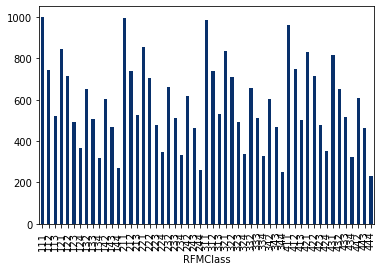

In [ ]:
# Vẽ biểu đồ 
rfmSeg.groupby('RFMClass').agg('monetary_value').mean().plot(kind='bar', colormap='Blues_r')

Em nhận thấy cách này không hay vì biểu đồ của em nhìn chen chút sợ quá thầy ơi nên em làm theo cách 2 ạ 

In [ ]:
# Cách thứ 2: Để kết hợp các điểm số thành một con số để so sánh em sẽ cộng lại với nhau ví dụ 1 + 1 + 1 =3 như vậy dữ liệu trong trường hợp này sẽ 
# từ 3 (1 + 1 + 1) đến 12 (4 + 4 + 4)
rfmSeg['Total Score'] = rfmSeg['R_Quartile'] + rfmSeg['F_Quartile'] +rfmSeg['M_Quartile']

In [ ]:
# Show thông tin cách thứ 2 khi em cộng các điểm số lại với nhau 
print(rfmSeg.head(), rfmSeg.info())

<class 'pandas.core.frame.DataFrame'>
Index: 6884 entries, CS1112 to CS9000
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   recency         6884 non-null   float64
 1   frequency       6884 non-null   int64  
 2   monetary_value  6884 non-null   int64  
 3   R_Quartile      6884 non-null   int64  
 4   F_Quartile      6884 non-null   int64  
 5   M_Quartile      6884 non-null   int64  
 6   RFMClass        6884 non-null   object 
 7   Total Score     6884 non-null   int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 484.0+ KB
             recency  frequency  ...  RFMClass  Total Score
customer_id                      ...                       
CS1112          77.0          6  ...       344           11
CS1113          51.0         11  ...       222            6
CS1114          48.0         11  ...       221            5
CS1115          27.0         10  ...       122            5
CS1116         219

In [ ]:
# Group các khách hàng cùng 1 nhóm lại với nhau bằng Monetary value 
# Như vậy ở đây em có các group từ 3 đến 12 số lượng group này sẽ ít hơn ở cách 1 
rfmSeg.groupby('Total Score').agg('monetary_value').mean()  

Total Score
3     1001.289963
4      952.057621
5      849.503277
6      741.711462
7      629.974101
8      557.809645
9      447.638221
10     385.731672
11     335.414443
12     230.907975
Name: monetary_value, dtype: float64

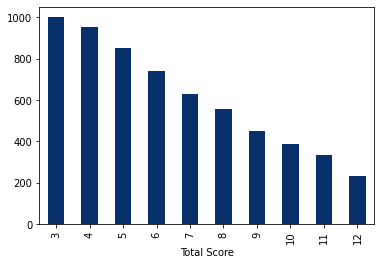

In [ ]:
# vẽ biểu đồ theo Monetary Value 
rfmSeg.groupby('Total Score').agg('monetary_value').mean().plot(kind='bar', colormap='Blues_r')

In [ ]:
#Group theo Frequency 
rfmSeg.groupby('Total Score').agg('frequency').mean()

Total Score
3     14.122677
4     13.486989
5     12.233290
6     10.885375
7      9.648921
8      8.742386
9      7.427885
10     6.689150
11     5.952904
12     4.684049
Name: frequency, dtype: float64

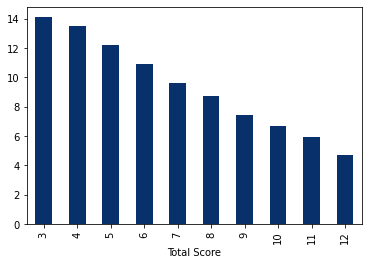

In [ ]:
# Vẽ biểu đồ theo Frequency 
rfmSeg.groupby('Total Score').agg('frequency').mean().plot(kind='bar', colormap='Blues_r')

In [ ]:
# Group nhóm theo Recency 
rfmSeg.groupby('Total Score').agg('recency').mean()

Total Score
3      25.949814
4      46.193309
5      62.499345
6      76.351779
7      68.966906
8      86.666244
9      89.254808
10    105.727273
11    146.660911
12    246.274540
Name: recency, dtype: float64

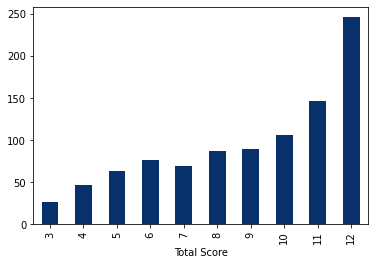

In [ ]:
# Vẽ biểu đồ theo Recency
rfmSeg.groupby('Total Score').agg('recency').mean().plot(kind='bar', colormap='Blues_r')